# Importing the libraries

In [204]:
!pip install alpha_vantage
import time
program_start = time.time()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import os
from scipy.stats import linregress

# API key and ticker symbol

In [205]:
av_key = 'HDHS7RJSLYNN07J7l'
#os.environ.get('av_key')
ticker = 'TSLA'

# Importing the dataset

In [206]:
ts = TimeSeries(key=av_key, output_format = 'pandas')
df, meta_data = ts.get_daily(symbol=ticker, outputsize='full')
df = df.reindex(index=df.index[::-1])
df = df.reset_index()
df.head()

,date,1. open,2. high,3. low,4. close,5. volume
0,2010-06-29,19.00,25.0000,17.54,23.89,18766300.0
1,2010-06-30,25.79,30.4192,23.30,23.83,17187100.0
2,2010-07-01,25.00,25.9200,20.27,21.96,8218800.0
3,2010-07-02,23.00,23.1000,18.71,19.20,5139800.0
4,2010-07-06,20.00,20.0000,15.83,16.11,6866900.0


In [207]:
dfi, meta_data_i = ts.get_intraday(symbol=ticker, outputsize='full', interval='1min')
dfi = dfi.reindex(index=dfi.index[::-1])
dfi = dfi.reset_index()
dfi.head()

,date,1. open,2. high,3. low,4. close,5. volume
0,2020-07-15 04:01:00,1576.0,1576.00,1576.0,1576.0,539.0
1,2020-07-15 04:14:00,1561.0,1563.31,1560.0,1560.0,1046.0
2,2020-07-15 04:18:00,1550.6,1550.60,1550.6,1550.6,345.0
3,2020-07-15 04:19:00,1545.0,1545.00,1545.0,1545.0,689.0
4,2020-07-15 04:22:00,1550.0,1550.00,1550.0,1550.0,404.0


In [208]:
df.describe

<bound method NDFrame.describe of            date  1. open    2. high   3. low  4. close   5. volume
0    2010-06-29    19.00    25.0000    17.54     23.89  18766300.0
1    2010-06-30    25.79    30.4192    23.30     23.83  17187100.0
2    2010-07-01    25.00    25.9200    20.27     21.96   8218800.0
3    2010-07-02    23.00    23.1000    18.71     19.20   5139800.0
4    2010-07-06    20.00    20.0000    15.83     16.11   6866900.0
...         ...      ...        ...      ...       ...         ...
2528 2020-07-15  1543.00  1550.0000  1457.00   1546.01  16368700.0
2529 2020-07-16  1477.16  1531.7100  1466.00   1500.64  14300800.0
2530 2020-07-17  1513.45  1537.5100  1490.00   1500.84   9332600.0
2531 2020-07-20  1519.01  1650.0000  1488.00   1643.00  16697300.0
2532 2020-07-21  1639.93  1675.0000  1558.00   1568.36  16029800.0

[2533 rows x 6 columns]>

In [209]:
df = df.drop('date', axis=1)
df.head()

,1. open,2. high,3. low,4. close,5. volume
0,19.00,25.0000,17.54,23.89,18766300.0
1,25.79,30.4192,23.30,23.83,17187100.0
2,25.00,25.9200,20.27,21.96,8218800.0
3,23.00,23.1000,18.71,19.20,5139800.0
4,20.00,20.0000,15.83,16.11,6866900.0


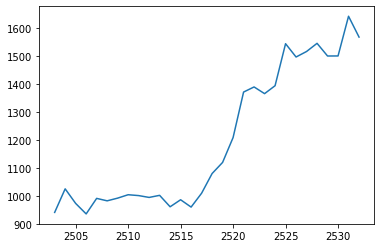

In [210]:
plt.plot(df['4. close'][-30:])

# Data preprocessing

In [211]:
df.columns = ['o', 'h', 'l', 'c', 'vol'] #Renaming columns
color, rng, u_shadow, l_shadow, ub, lb = [], [], [], [], [], []

for ind in df.index:
    rng.append(df['h'][ind] - df['l'][ind]) #Calculating range
    
    if df['o'][ind] > df['c'][ind]:
        color.append('red') #open higher than close --> bearishness
    else:
        color.append('blue') #open is lower than or equal to close --> bulllishness

    if color[::-1] == 'red':  #Determining shadow length and bounds for red candles
        u_shadow.append(df['h'][ind] - df['o'][ind])
        l_shadow.append(df['c'][ind] - df['l'][ind])
        ub.append(df['o'][ind])
        lb.append(df['c'][ind])
    else: #Determining shadow length and bounds for blue candles
        u_shadow.append(df['h'][ind] - df['c'][ind])
        l_shadow.append(df['o'][ind] - df['l'][ind])
        ub.append(df['c'][ind])
        lb.append(df['o'][ind])
        
df['color'] = color
df['range'] = rng
df['u_shadow'] = u_shadow
df['l_shadow'] = l_shadow
df['u_bound'] = ub
df['l_bound'] = lb
df.head()

,o,h,l,c,vol,color,range,u_shadow,l_shadow,u_bound,l_bound
0,19.00,25.0000,17.54,23.89,18766300.0,blue,7.4600,1.1100,1.46,23.89,19.00
1,25.79,30.4192,23.30,23.83,17187100.0,red,7.1192,6.5892,2.49,23.83,25.79
2,25.00,25.9200,20.27,21.96,8218800.0,red,5.6500,3.9600,4.73,21.96,25.00
3,23.00,23.1000,18.71,19.20,5139800.0,red,4.3900,3.9000,4.29,19.20,23.00
4,20.00,20.0000,15.83,16.11,6866900.0,red,4.1700,3.8900,4.17,16.11,20.00


## Function to find prior trend


In [212]:
def prior_trend(ind, df, span):
  temp1 = []
  temp2 = []
  for i in range(ind - span, ind):
    temp1.append(df[i])
    temp2.append(float(i))
  slope, inter, rval, pval, stderr = linregress(temp2, temp1)
  if slope < 0:
    trend = 'down'
  else:
    trend = 'up'
  return trend

# Single candlestick patterns

In [213]:
s_pattern = []
for ind in df.index:
    if df['u_shadow'][ind] == df['l_shadow'][ind]:
        if df['range'][ind] >= 0.005:
            s_pattern.append('spinning top')
        else:
            s_pattern.append('doji')
    elif (df['u_shadow'][ind]/df['u_bound'][ind] <= 0.003 and
          df['l_shadow'][ind]/df['l_bound'][ind] <= 0.003):
        s_pattern.append('marubozu')
    elif ((df['l_shadow'][ind] < 0.003 and 
           df['u_shadow'][ind] > 2*df['range'][ind]) and 
          prior_trend(ind, df['c'], 30) == 'up'):
        s_pattern.append('shooting star')
    elif df['u_shadow'][ind] < 0.003 and df['l_shadow'][ind] >= 2*df['range'][ind]:
        if prior_trend(ind, df[c], 30) == 'down':
          s_pattern.append('hammer')
        else:
          s_pattern.append('hanging')
    else:
        s_pattern.append('others')
df['s_pattern'] = s_pattern
df.tail()

,o,h,l,c,vol,color,range,u_shadow,l_shadow,u_bound,l_bound,s_pattern
2528,1543.00,1550.00,1457.0,1546.01,16368700.0,blue,93.00,3.99,86.00,1546.01,1543.00,others
2529,1477.16,1531.71,1466.0,1500.64,14300800.0,blue,65.71,31.07,11.16,1500.64,1477.16,others
2530,1513.45,1537.51,1490.0,1500.84,9332600.0,red,47.51,36.67,23.45,1500.84,1513.45,others
2531,1519.01,1650.00,1488.0,1643.00,16697300.0,blue,162.00,7.00,31.01,1643.00,1519.01,others
2532,1639.93,1675.00,1558.0,1568.36,16029800.0,red,117.00,106.64,81.93,1568.36,1639.93,others


## Analysing single candlestick pattern detection results

In [214]:
count = df['s_pattern'].value_counts()
print(count)

others          2471
marubozu          54
spinning top       8
Name: s_pattern, dtype: int64


In [215]:
for ind in df.index:
  if df['s_pattern'][ind] != 'others':
    print(df.loc[[ind]])

        o      h     l     c  ...  l_shadow u_bound  l_bound  s_pattern
49  20.66  20.95  20.6  20.9  ...      0.06    20.9    20.66   marubozu

[1 rows x 12 columns]
        o      h      l      c  ...  l_shadow u_bound  l_bound  s_pattern
64  21.19  22.03  21.13  21.98  ...      0.06   21.98    21.19   marubozu

[1 rows x 12 columns]
         o      h     l     c  ...  l_shadow u_bound  l_bound  s_pattern
102  31.57  33.45  31.5  33.4  ...      0.07    33.4    31.57   marubozu

[1 rows x 12 columns]
         o      h      l     c  ...  l_shadow u_bound  l_bound     s_pattern
211  27.69  27.87  27.42  27.6  ...      0.27    27.6    27.69  spinning top

[1 rows x 12 columns]
         o      h      l      c  ...  l_shadow u_bound  l_bound     s_pattern
232  29.69  30.28  29.55  30.14  ...      0.14   30.14    29.69  spinning top

[1 rows x 12 columns]
         o     h        l      c  ...  l_shadow u_bound  l_bound  s_pattern
351  33.48  35.0  33.4029  34.94  ...    0.0771   34.94    33

# Multiple candlestick patterns

In [216]:
m_pattern = []
for ind in df.index:
  if (prior_trend(ind, df['c'], 30) == 'down'): 
     if (df['color'][ind]  == 'red'): 
        if (df['color'][ind+1] == 'blue'):
          if (df['range'][ind+1] > df['range'][ind]):
            if (df['open'][ind+1] <= df['close'][ind]):
              m_pattern.append('bullEngulf')
              m_pattern.append('bullEngulf')
  elif ((prior_trend(ind, df['c'], 30) == 'up') and
        (df['color'][ind]  == 'blue') and
        (df['color'][ind+1] == 'red') and
        (df['range'][ind+1] > df['range'][ind]) and
        (df['open'][ind+1] <= df['close'][ind])):
      m_pattern.append('bearEngulf')
      m_pattern.append('bearEngulf')

KeyError: ignored

In [218]:
for ind in df.index:
  if ((prior_trend(ind, df['c'], 5) == 'down') and
      (df['color'][ind] == 'red') and
      (df['color'][ind+1] == 'blue') and
      (df['range'][ind+1] > df['range'][ind]) and
      (df['o'][ind+1] <= df['c'][ind])):
    m_pattern.append('bullEngulf')

KeyError: ignored

# Real time


In [ ]:
if (df['s_pattern'][-1] == 'doji' and
    df['m_pattern'][-2] == 'bullEngulf'):
  signal = 'short'
  stoploss = max(df['u_bound'][-2], df['u_bound'][-3])
  short = df['c'][-2]
  target = 1.1*short 

In [ ]:
program_end = time.time()
print("Runtime = {0}".format(program_end - program_start))